# DS2002 Data Project 1
## Christopher Joseph (F24)

# Part 1: CSV to JSON to SQL

## Section 1: Fetch / download / retrieve a remote data file by URL, or ingest a local file 
The file I chose to download was a csv file on Federal Reserve Interest rates over time.

In [11]:
import pandas as pd

url = 'https://github.com/ChrisxCross2003/DS2002F24/blob/main/interest_rates.csv?raw=true'
try:
    df = pd.read_csv(url, index_col=0)
    print(df.head(5))
except Exception as e:
    print(f"Invalid link! Please check if the link was typed correctly. Error details: {e}")

      Month  Day  Federal Funds Target Rate  Federal Funds Upper Target  \
Year                                                                      
1954      7    1                        NaN                         NaN   
1954      8    1                        NaN                         NaN   
1954      9    1                        NaN                         NaN   
1954     10    1                        NaN                         NaN   
1954     11    1                        NaN                         NaN   

      Federal Funds Lower Target  Effective Federal Funds Rate  \
Year                                                             
1954                         NaN                          0.80   
1954                         NaN                          1.22   
1954                         NaN                          1.06   
1954                         NaN                          0.85   
1954                         NaN                          0.83   

      Real 

## Section 2: Pre-Processing Summary
Let's summarize the data we are ingesting, more specifically, let's look at two attributes:
1. Number of Rows
2. Number of Columns

In [70]:
# Number of rows
print("Number of rows ingested: "+str(len(df.index)))

# Number of Columns
print("Number of columns ingested: "+str(len(df.columns)))

Number of rows ingested: 904
Number of columns ingested: 9


## Section 3: Modifying the Data
- Since some columns, like "target interest rate" are not used for all years, let's clean up our data and delete these columns.
- This allows us to retain only the available information for all years, and delete any irrelevant data for optimal storage.

In [75]:
# It would be easier to trim the dataframe before converting to a JSON string, so let's specify which columns we want to keep.
df.reset_index(inplace=True)
columns_to_keep = ['Year', 'Month', 'Day', 'Effective Federal Funds Rate', 'Unemployment Rate', 'Inflation Rate']
df2 = df[columns_to_keep]

## Section 4: Post-Processing Summary

In [77]:
# Doublecheck if the columns have changed, but the rows haven't.
print("Number of rows exported: "+str(len(df2.index)))
print("Number of columns exported: "+str(len(df2.columns)))

if (len(df2.columns) < len(df.columns)) and (len(df2.index) == len(df.index)):
    print("Trimming was successful!")
else:
    print("Trimming unsuccessful. Ensure you're creating a subset DataFrame from the original!")

Number of rows exported: 904
Number of columns exported: 6
Trimming was successful!


## Section 5: Converting DF to JSON

In [155]:
# pandas has a built-in df-to-json converter. Found information here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_json.html
result = df2.to_json(orient='records', lines=True)
# print(result) Debugging only, very long output.

## Section 6: Converting from JSON to SQL
- Let's store the JSON dataframe into an SQL database!

In [103]:
import json
import sqlite3

# Parse the JSON data (result is the JSON string)
inflation_data = result.splitlines()  # Split JSON data by lines into a list of JSON strings
parsed_data = [json.loads(entry) for entry in inflation_data]  # Parse each JSON string into a dictionary


# Connect to SQLite
conn = sqlite3.connect('federal_reserve.db')
c = conn.cursor()

# Create a table
c.execute('''
    CREATE TABLE IF NOT EXISTS inflation_rates (
        Year INTEGER,
        Month INTEGER,
        Day INTEGER,
        "Effective Federal Funds Rate" REAL,
        "Unemployment Rate" REAL,
        "Inflation Rate" REAL
    )
''')

# Insert JSON data into the SQLite table
for entry in parsed_data:
    c.execute('''
        INSERT INTO inflation_rates (Year, Month, Day, "Effective Federal Funds Rate", "Unemployment Rate", "Inflation Rate")
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (entry['Year'], entry['Month'], entry['Day'], entry['Effective Federal Funds Rate'], entry['Unemployment Rate'], entry['Inflation Rate']))

# Commit and close the connection
conn.commit()
conn.close()

## Section 7: Querying our Database to confirm processing is successful

### 7a: Show all data from the year 2000.

In [139]:
# Connect to SQLite
conn = sqlite3.connect('federal_reserve.db')
c = conn.cursor()

# Select all data from the year 2000.
c.execute('''
SELECT * FROM inflation_rates WHERE YEAR = 2000
''')

# Fetch and display the results
joined_data = c.fetchall()

print("All Inflation Data from the year 2000:\n")

# Getting column headers (used ChatGPT for assistance on showing the headers, since there is no sqlite method to do this)
headers = [description[0] for description in c.description]

# Print the headers
print(" | ".join(headers))

for row in joined_data:
    print(row)

conn.commit()
conn.close()

All Inflation Data from the year 2000:

Year | Month | Day | Effective Federal Funds Rate | Unemployment Rate | Inflation Rate
(2000, 1, 1, 5.45, 4.0, 2.0)
(2000, 2, 1, 5.73, 4.1, 2.2)
(2000, 2, 2, None, None, None)
(2000, 3, 1, 5.85, 4.0, 2.4)
(2000, 3, 21, None, None, None)
(2000, 4, 1, 6.02, 3.8, 2.3)
(2000, 5, 1, 6.27, 4.0, 2.4)
(2000, 5, 16, None, None, None)
(2000, 6, 1, 6.53, 4.0, 2.5)
(2000, 7, 1, 6.54, 4.0, 2.5)
(2000, 8, 1, 6.5, 4.1, 2.6)
(2000, 9, 1, 6.52, 3.9, 2.6)
(2000, 10, 1, 6.51, 3.9, 2.5)
(2000, 11, 1, 6.51, 3.9, 2.6)
(2000, 12, 1, 6.4, 3.9, 2.6)


### 7b. Find the average Inflation rate for 2008

In [137]:
# Connect to SQLite
conn = sqlite3.connect('federal_reserve.db')
c = conn.cursor()

# Select the average inflation rate from the year 2000.
c.execute('''
SELECT AVG("Inflation Rate") FROM inflation_rates WHERE YEAR = 2008
''')

# Fetch and display the results
joined_data = c.fetchone()

print("Average Inflation Rate from 2008:\n")

for row in joined_data:
    print(row)

conn.commit()
conn.close()

Average Inflation Rate from 2008:

2.308333333333333


### 7c: List the average inflation rates for each year in our dataset.

(1954, None)
(1955, None)
(1956, None)
(1957, None)
(1958, 2.283333333333333)
(1959, 1.9916666666666665)
(1960, 1.5250000000000001)
(1961, 1.125)
(1962, 1.375)
(1963, 1.2750000000000001)
(1964, 1.5)
(1965, 1.4416666666666667)
(1966, 2.4166666666666665)
(1967, 3.475)
(1968, 4.633333333333334)
(1969, 5.808333333333334)
(1970, 6.241666666666667)
(1971, 4.708333333333333)
(1972, 3.0666666666666664)
(1973, 3.4916666666666667)
(1974, 8.208333333333334)
(1975, 9.291666666666666)
(1976, 6.566666666666666)
(1977, 6.258333333333333)
(1978, 7.3)
(1979, 9.716666666666667)
(1980, 12.433333333333332)
(1981, 10.483333333333333)
(1982, 7.4750000000000005)
(1983, 3.9333333333333336)
(1984, 4.941666666666666)
(1985, 4.375)
(1986, 4.058333333333334)
(1987, 4.125)
(1988, 4.416666666666667)
(1989, 4.516666666666667)
(1990, 5.016666666666667)
(1991, 4.8999999999999995)
(1992, 3.65)
(1993, 3.3083333333333336)
(1994, 2.8499999999999996)
(1995, 2.9916666666666667)
(1996, 2.716666666666667)
(1997, 2.39166666666

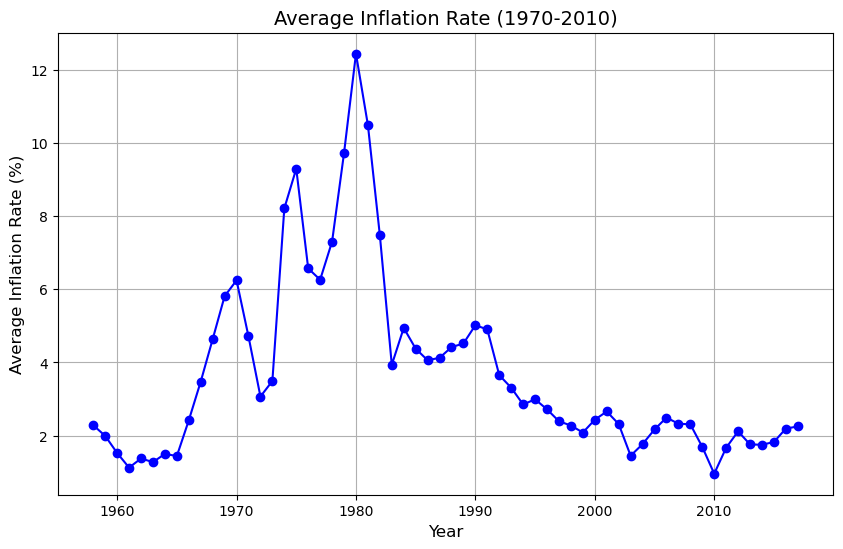

In [153]:
import matplotlib.pyplot as plt

# Connect to SQLite
conn = sqlite3.connect('federal_reserve.db')
c = conn.cursor()

# SQL query to calculate average inflation rates for each year from 1970 to 2010
c.execute('''
SELECT Year, AVG("Inflation Rate") FROM inflation_rates
GROUP BY Year
ORDER BY Year
''')

data = c.fetchall()

# We can list the data...
for row in data:
    print(row)

# Or we can work to plot it! (following example from sqlite plotting HW)
# Used ChatGPT for help in splitting the years from the values to plot successfully
years = [row[0] for row in data]
avg_inflation_rates = [row[1] for row in data]

# copied from SQLite HW
plt.figure(figsize=(10, 6))
plt.plot(years, avg_inflation_rates, marker='o', color='b', linestyle='-', label='Avg Inflation Rate')

# Adding labels and title (https://www.w3schools.com/python/matplotlib_labels.asp)
plt.title('Average Inflation Rate (1970-2010)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Inflation Rate (%)', fontsize=12)

plt.grid(True)
plt.show()

conn.commit()
conn.close()

# Part 2: JSON to CSV to SQL

## Section 1: Fetch / download / retrieve a remote data file by URL, or ingest a local file 
The file I chose to download was a JSON file on GDP Data of Different Countries over time. This data was taken from a sample Github Source, and is not meant to be treated as real-world data.

In [27]:
import pandas as pd

url = 'https://github.com/ChrisxCross2003/DS2002F24/blob/main/population_data.json?raw=true'

# try to read the url using the pandas read json command (code taken from one of our homeworks).
try:
    df1 = pd.read_json(url)
    print(df1.head(5))
except Exception as e:
    # If this fails, throw an error
    print(f"Invalid link! Please check if the link was typed correctly. Error details: {e}")
    

  Country Name Country Code  Year        Value
0   Arab World          ARB  1960   96388069.0
1   Arab World          ARB  1961   98882541.4
2   Arab World          ARB  1962  101474075.8
3   Arab World          ARB  1963  104169209.2
4   Arab World          ARB  1964  106978104.6


## Section 2: Pre-Processing Summary
Let's summarize the data we are ingesting, more specifically, let's look at two attributes:
-
Number of R- - s
Number of Cmnluns


In [7]:
# Number of rows
print("Number of rows ingested: "+str(len(df1.index)))

# Number of Columns
print("Number of columns ingested: "+str(len(df1.columns)))

Number of rows ingested: 12407
Number of columns ingested: 4


## Section 3: Modifying the Data
- One column called "Value" does not give us proper insight into what the data is showing. We need to rename this column to a more specific value, so that the reader can understand what the data refers to without using external references.
- It would also make sense to delete any data points that are classified as territories since they are not the data we want to focus on.

In [9]:
# rename the "value" column to be more specific.
df1.rename(columns={"Value": "Gross Domestic Product"}, inplace=True)

# create a list of data names to exclude from our final df since they are territories and not countries.
territories_to_exclude = [
    "New Caledonia", "Northern Mariana Islands", "Puerto Rico",
    "Turks and Caicos Islands", "Virgin Islands (U.S.)", "Mayotte",
    "Isle of Man", "Guam", "Greenland", "Gibraltar", "Faeroe Islands",
    "Curacao", "Channel Islands", "Bermuda", "American Samoa"
]

# Filter out territories
df1_filtered = df1[~df1['Country Name'].isin(territories_to_exclude)]

# Display the filtered DataFrame
print(df1_filtered.head(5))

  Country Name Country Code  Year  Gross Domestic Product
0   Arab World          ARB  1960              96388069.0
1   Arab World          ARB  1961              98882541.4
2   Arab World          ARB  1962             101474075.8
3   Arab World          ARB  1963             104169209.2
4   Arab World          ARB  1964             106978104.6


## Section 4: Post-Processing Summary
Given that some data points were deleted, we should expect a decrease in the number of rows but not the number of columns. 

In [11]:
# Number of rows
print("Number of rows ingested: "+str(len(df1_filtered.index)))

# Number of Columns
print("Number of columns ingested: "+str(len(df1_filtered.columns)))

if ((len(df1_filtered.index) >= len(df1.index)) or (len(df1_filtered.columns) != len(df1.columns))):
    print("It appears the data was incorrectly modified, please double-check the code for bugs.")
else:
    print("Data modification successful!")
    

Number of rows ingested: 11680
Number of columns ingested: 4
Data modification successful!


## Section 5: Converting DF to CSV

In [13]:
# Convert DataFrame to CSV
df1_filtered.to_csv('filtered_dataframe.csv', index=False)
print("csv exported!")

csv exported!


## Section 6: Converting CSV to SQL

In [15]:
import sqlite3

# read the csv into a dataframe using the built-in pandas command.
df = pd.read_csv('filtered_dataframe.csv')

# from there, we can connect the df to an sql database with the built-in command!
conn = sqlite3.connect('country_wealth.db')
df.to_sql('Countries', conn, if_exists='replace', index=False)

conn.close()
print("database created!")

database created!


## Section 7: Testing SQL

In [ ]:
### 7a. All Country GDPs from 2000

In [17]:
# Connect to SQLite
conn = sqlite3.connect('country_wealth.db')
c = conn.cursor()

# Select all countries from the year 2000.
c.execute('''
SELECT * FROM Countries WHERE YEAR = 2000
''')

# Fetch and display the results
joined_data = c.fetchall()

print("All Country GDPs from the year 2000:\n")

# Getting column headers (used ChatGPT for assistance on showing the headers, since there is no sqlite method to do this)
headers = [description[0] for description in c.description]

# Print the headers
print(" | ".join(headers))

for row in joined_data:
    print(row)

conn.commit()
conn.close()

All Country GDPs from the year 2000:

Country Name | Country Code | Year | Gross Domestic Product
('Arab World', 'ARB', 2000, 285376280.293994)
('Caribbean small states', 'CSS', 2000, 6453378.55137656)
('East Asia & Pacific (all income levels)', 'EAS', 2000, 2044996322.0)
('East Asia & Pacific (developing only)', 'EAP', 2000, 1813796742.0)
('Euro area', 'EMU', 2000, 315000148.0)
('Europe & Central Asia (all income levels)', 'ECS', 2000, 862063708.642516)
('Europe & Central Asia (developing only)', 'ECA', 2000, 398510208.642517)
('European Union', 'EUU', 2000, 483527101.0)
('Heavily indebted poor countries (HIPC)', 'HPC', 2000, 491037247.5)
('High income', 'HIC', 2000, 1049573305.61653)
('High income: nonOECD', 'NOC', 2000, 75790192.6165284)
('High income: OECD', 'OEC', 2000, 973783113.0)
('Latin America & Caribbean (all income levels)', 'LCN', 2000, 520373971.5758)
('Latin America & Caribbean (developing only)', 'LAC', 2000, 514251596.959271)
('Least developed countries: UN classificat

### 7b. All Countries starting with S and from 2001

In [19]:
# Connect to SQLite
conn = sqlite3.connect('country_wealth.db')
c = conn.cursor()

## Select all countries where country code starts with S.
c.execute('''
SELECT * FROM Countries
WHERE "Country Code" LIKE 'S%' AND YEAR = 2001
''')

# Fetch and display the results
joined_data = c.fetchall()

print("All Countries with country codes starting with S:\n")

for row in joined_data:
    print(row)

conn.commit()
conn.close()

All Countries with country codes starting with S:

('Small states', 'SST', 2001, 25142740.4806712)
('South Asia', 'SAS', 2001, 1422342004.19361)
('Sub-Saharan Africa (all income levels)', 'SSF', 2001, 683959278.861608)
('Sub-Saharan Africa (developing only)', 'SSA', 2001, 683422083.861608)
('El Salvador', 'SLV', 2001, 5966027.0)
('San Marino', 'SMR', 2001, 27543.0)
('Sao Tome and Principe', 'STP', 2001, 143430.0)
('Saudi Arabia', 'SAU', 2001, 20681576.0)
('Senegal', 'SEN', 2001, 9758841.0)
('Serbia', 'SRB', 2001, 7503433.0)
('Seychelles', 'SYC', 2001, 81202.0)
('Sierra Leone', 'SLE', 2001, 4303850.0)
('Singapore', 'SGP', 2001, 4138000.0)
('Sint Maarten (Dutch part)', 'SXM', 2001, 31189.0)
('Slovak Republic', 'SVK', 2001, 5378867.0)
('Slovenia', 'SVN', 2001, 1992060.0)
('Solomon Islands', 'SLB', 2001, 420232.0)
('Somalia', 'SOM', 2001, 7596920.0)
('Sudan', 'SDN', 2001, 35002234.0)
('Suriname', 'SUR', 2001, 473431.0)
('Swaziland', 'SWZ', 2001, 1012110.86160827)
('Sweden', 'SWE', 2001, 88

### 7c. All Countries with a GDP over 500 million in 1987

In [25]:
# Connect to SQLite
conn = sqlite3.connect('country_wealth.db')
c = conn.cursor()

## Select all countries where GDP is more than 500 million in the year 1987.
c.execute('''
SELECT * FROM Countries
WHERE "Gross Domestic Product" > 500000000 AND YEAR = 1987
''')

# Fetch and display the results
joined_data = c.fetchall()

print("All Countries in 1987 with a GDP over 500 million:\n")

for row in joined_data:
    print(row)

conn.commit()
conn.close()

All Countries in 1987 with a GDP over 500 million:

('East Asia & Pacific (all income levels)', 'EAS', 1987, 1738262202.35216)
('East Asia & Pacific (developing only)', 'EAP', 1987, 1526043132.51293)
('Europe & Central Asia (all income levels)', 'ECS', 1987, 828175017.397117)
('High income', 'HIC', 1987, 957931340.439235)
('High income: OECD', 'OEC', 1987, 896463935.0)
('Low & middle income', 'LMY', 1987, 4072880372.41119)
('Lower middle income', 'LMC', 1987, 1663438382.48423)
('Middle income', 'MIC', 1987, 3605974717.82173)
('OECD members', 'OED', 1987, 1039690799.0)
('South Asia', 'SAS', 1987, 1072274632.58946)
('Upper middle income', 'UMC', 1987, 1942536335.33749)
('World', 'WLD', 1987, 5030811712.85042)
('China', 'CHN', 1987, 1084035000.0)
('India', 'IND', 1987, 819800055.0)


# Part 3: One Pager
Submit a 1 pager on the your experience reflecting on the challenges, what was easier than you thought and what was harder. How would a utility like this be useful for other data projects you may encounter?

Reflecting on the challenges faced during this project, I found the experience to be very insightful! One aspect that was easier than expected was working with SQL queries. I really enjoyed that part of the project since I was already somewhat familiar with SQL queries, and the SQLLite dataframe was very easy to navigate. Also, discovering that pandas had built-in commands for dataframe conversions was a very pleasant surprise! These functions made the process of converting data from JSON-to-df and df-to-JSON much smoother and more intuitive, which saved me a lot of time and effort.

I did encounter some challenges, however. For one, ingesting data from URLs proved to be tricky. On some sites like Kaggle, even though I was signed up, I struggled to get direct download links that would work with the Python URL reader. I ultimately found the URL link via Google Chrome’s "Inspect" tool, to retrieve the public download link, and GitHub for another link. Another significant challenge was handling JSON files in general. Initially, modifying the JSON files directly was very difficult, so I pivoted to converting them to dataframes, making the modifications I needed, and then converting them back to JSON format.

Tools like SQLite, pandas dataframes, and CSV files made the remainder of the project much more manageable. After converting the JSON files, it became simpler to manipulate and analyze the data. Overall, I had a lot of fun with this project!

Looking ahead, I anticipate using these techniques in future projects. In learning how to make a data pipeline myself, I feel it really helps to understand the bigger picture of why data conversion and manipulation is important for data analysis. Rather than focusing solely on the results, how do we get to our results? In this project, I feel that I became a lot more confident in answering that question.r?